## Problem
You are given data from an Audiobook App. Logically, it relates to the audio versions of books ONLY. Each customer in the database has made a purchase at least once, that's why he/she is in the database. We want to create a machine learning algorithm based on our available data that can predict if a customer will buy again from the Audiobook company.

The main idea is that if a customer has a low probability of coming back, there is no reason to spend any money on advertising to him/her. If we can focus our efforts SOLELY on customers that are likely to convert again, we can make great savings. Moreover, this model can identify the most important metrics for a customer to come back again. Identifying new customers creates value and growth opportunities.

You have a .csv summarizing the data. There are several variables: Customer ID, ), Book length overall (sum of the minute length of all purchases), Book length avg (average length in minutes of all purchases), Price paid_overall (sum of all purchases) ,Price Paid avg (average of all purchases), Review (a Boolean variable whether the customer left a review), Review out of 10 (if the customer left a review, his/her review out of 10, Total minutes listened, Completion (from 0 to 1), Support requests (number of support requests; everything from forgotten password to assistance for using the App), and Last visited minus purchase date (in days).

These are the inputs (excluding customer ID, as it is completely arbitrary. It's more like a name, than a number).

The targets are a Boolean variable (0 or 1). We are taking a period of 2 years in our inputs, and the next 6 months as targets. So, in fact, we are predicting if: based on the last 2 years of activity and engagement, a customer will convert in the next 6 months. 6 months sounds like a reasonable time. If they don't convert after 6 months, chances are they've gone to a competitor or didn't like the Audiobook way of digesting information.

The task is simple: create a machine learning algorithm, which is able to predict if a customer will buy again.

This is a classification problem with two classes: won't buy and will buy, represented by 0s and 1s.

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.under_sampling import RandomUnderSampler

from sklearn.preprocessing import scale
from sklearn.compose import make_column_selector as selector
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn import tree, metrics
from IPython.display import Image  
import pydotplus

from xgboost import XGBClassifier, cv, plot_importance
from sklearn.ensemble import RandomForestClassifier


from sklearn.metrics import classification_report, roc_auc_score, f1_score, precision_recall_curve, accuracy_score, confusion_matrix, balanced_accuracy_score
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline


from sklearn.metrics import fbeta_score, make_scorer

import itertools

import warnings
warnings.filterwarnings('ignore')

from imblearn.under_sampling import RandomUnderSampler

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.compose import ColumnTransformer

from sklearn.inspection import permutation_importance


### Import the data

In [8]:
df = pd.read_csv('C:\\Users\\somfl\\Downloads\\Audiobooks_data.csv',delimiter=',')

In [9]:
df.head()

,00994,1620,1620.1,19.73,19.73.1,1,10.00,0.99,1603.80,5,92,0
0,1143,2160.0,2160,5.33,5.33,0,8.91,0.00,0.0,0,0,0
1,2059,2160.0,2160,5.33,5.33,0,8.91,0.00,0.0,0,388,0
2,2882,1620.0,1620,5.96,5.96,0,8.91,0.42,680.4,1,129,0
3,3342,2160.0,2160,5.33,5.33,0,8.91,0.22,475.2,0,361,0
4,3416,2160.0,2160,4.61,4.61,0,8.91,0.00,0.0,0,0,0


In [10]:
df.columns

Index(['00994', '1620', '1620.1', '19.73', '19.73.1', '1', '10.00', '0.99',
       '1603.80', '5', '92', '0'],
      dtype='object')

In [11]:
df.isna().sum()

00994      0
1620       0
1620.1     0
19.73      0
19.73.1    0
1          0
10.00      0
0.99       0
1603.80    0
5          0
92         0
0          0
dtype: int64

In [24]:
X = df.iloc[:, 1:-1]
y = df.iloc[:,-1]

In [25]:
X

,1620,1620.1,19.73,19.73.1,1,10.00,0.99,1603.80,5,92
0,2160.0,2160,5.33,5.33,0,8.91,0.00,0.0,0,0
1,2160.0,2160,5.33,5.33,0,8.91,0.00,0.0,0,388
2,1620.0,1620,5.96,5.96,0,8.91,0.42,680.4,1,129
3,2160.0,2160,5.33,5.33,0,8.91,0.22,475.2,0,361
4,2160.0,2160,4.61,4.61,0,8.91,0.00,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...
14078,1620.0,1620,5.33,5.33,1,9.00,0.61,988.2,0,4
14079,1080.0,1080,6.55,6.55,1,6.00,0.29,313.2,0,29
14080,2160.0,2160,6.14,6.14,0,8.91,0.00,0.0,0,0
14081,1620.0,1620,5.33,5.33,1,8.00,0.38,615.6,0,90


In [26]:
y

0        0
1        0
2        0
3        0
4        0
        ..
14078    0
14079    0
14080    0
14081    0
14082    1
Name: 0, Length: 14083, dtype: int64

In [27]:
y.value_counts()

0    11846
1     2237
Name: 0, dtype: int64

In [29]:
## Balance Data Set
Xn = X.to_numpy()
yn = y.to_numpy()
random_state=42
RU = RandomUnderSampler()
X_res, y_res = RU.fit_resample(Xn,yn)
X_res

### Preprocess the data

In [33]:


X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, stratify=y_res, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.15, random_state=42)


In [41]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_tr_scaled = scaler.transform(X_train)
X_te_scaled = scaler.transform(X_test)
X_va_scaled = scaler.transform(X_val)


## Model

In [75]:


lr = Pipeline(
    [
       
        ("classifier", RandomForestClassifier(random_state=42))
    ]
)

In [76]:
cv_results = cross_validate(lr, X_tr_scaled, y_train, scoring = 'balanced_accuracy', cv=5)
cv_scores = cv_results['test_score']
cv_scores

array([0.76933831, 0.77659284, 0.81871345, 0.77923977, 0.78508772])

In [77]:
grid_params = { 
    'classifier__n_estimators': [50, 100, 150],
    'classifier__max_depth' : [3, 6, 9],
    'classifier__criterion' :['gini', 'entropy']
}

# Perform grid search
grid_cv = GridSearchCV(lr, param_grid=grid_params, cv=5, scoring = 'balanced_accuracy', n_jobs=-1)
grid_cv.fit(X_tr_scaled, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('classifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__criterion': ['gini', 'entropy'],
                         'classifier__max_depth': [3, 6, 9],
                         'classifier__n_estimators': [50, 100, 150]},
             scoring='balanced_accuracy')

In [61]:
grid_params = {'classifier__penalty': ['l1','l2'],
               'classifier__C': [0.1,100]          
}

# Perform grid search
grid_cv = GridSearchCV(lr, param_grid=grid_params, cv=5, scoring = 'balanced_accuracy', n_jobs=-1)
grid_cv.fit(X_tr_scaled, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('classifier',
                                        LogisticRegression(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.1, 100],
                         'classifier__penalty': ['l1', 'l2']},
             scoring='balanced_accuracy')

In [78]:
y_te_predict = grid_cv.best_estimator_.predict(X_test)
balanced_accuracy_score(y_test, y_te_predict)

0.7410714285714286

### Important Features

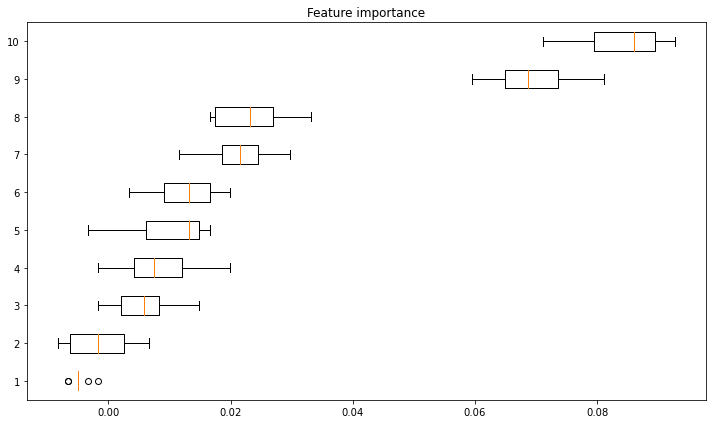

In [79]:

result = permutation_importance(
    grid_cv.best_estimator_, X_va_scaled, y_val, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(10,6))
ax.boxplot(
    result.importances[sorted_idx].T, vert=False
)
ax.set_title("Feature importance")
fig.tight_layout()
plt.show()


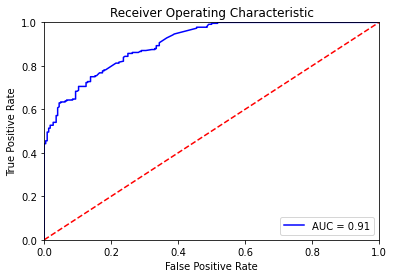

In [80]:
y_pred = grid_cv.best_estimator_.predict(X_te_scaled)
y_prob = grid_cv.best_estimator_.predict_proba(X_te_scaled)
probs = y_prob[:,1]
FalsePositiveRate, TruePositiveRate, threshold = metrics.roc_curve(y_test, probs)
roc_auc = metrics.auc(FalsePositiveRate, TruePositiveRate)

plt.title('Receiver Operating Characteristic')
plt.plot(FalsePositiveRate, TruePositiveRate, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()